In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns
sns.set_style('white') 
sns.set_context('talk')

import pandas as pd

from sklearn.model_selection import train_test_split

In [59]:
import numpy as _np
import scipy.special as _sp
from tqdm import tqdm as _tqdm

def _betaln(alphas):
    res = -_sp.gammaln(_np.sum(alphas))
    for a in alphas:
        res += _sp.gammaln(a)
    return res

def _beta(alphas):
    return _np.exp(_betaln(alphas))

class BayesMultiLinearModel:
    def __init__(self, n_models=20, mu = 0.1, epsilon = 10**(-30)):
        self.__n_models = n_models
        self.__mu = mu
        self.__epsilon = epsilon
        self.__A = None
        self.__b = None
        self.__beta = None
        
        
        self.__Z = None
        self.__gamma = None
        self.__B = None
        self.__m = None
        return
    
    def fit(self, X = None, p = None, epoch = 100):
        if X is None:
            return 1
        if p is None:
            return 1
        
        if self.__A is None:
            self.__A = _np.random.rand(self.__n_models, X.shape[1])
        if self.__b is None:
            self.__b = _np.random.rand(self.__n_models)*100000
        if self.__beta is None:
            self.__beta = 1
            
        return self.__fit(X, p, epoch)
    
    def __fit(self, X, p, epoch):
        self.__init_q(X, p)
        
        List_of_F = []
        
        for i in _tqdm(range(epoch)):
            self.__E_step(X, p)
#             self.__delete_bad_model(X, p)
            self.__M_step(X, p)
            List_of_F.append(self.__Func(X, p))
        return List_of_F
    
    def __Func(self, X, p):
        res = 0
        
        for k in range(self.__n_models):
            temp_1 = _sp.digamma(self.__mu + self.__gamma[k]) - _sp.digamma(self.__n_models*self.__mu + X.shape[0])
            temp_2 = _np.sum(1.0/self.__A[k])
            temp_3 = _np.sum(_np.diag(self.__B[k]) + _np.diag(_np.reshape(self.__m[k], [-1,1])@_np.reshape(self.__m[k], [1,-1]))*self.__A[k])
            
            temp_4 = 0
            temp_4_1 = temp_1 
            temp_4_2 = _np.log(self.__beta)
            temp_4_3 = _np.log(2*_np.pi)
            temp_4_6_1 = self.__B[k] + _np.reshape(self.__m[k], [-1,1])@_np.reshape(self.__m[k], [1,-1])
            for i in range(X.shape[0]):
                temp_4_4 = (p[i] - self.__b[k])**2
                temp_4_5 = (p[i] - self.__b[k])*_np.sum(self.__m[k]*X[i])
                temp_4_6_2 = _np.reshape(X[i], [-1,1])@_np.reshape(X[i], [1,-1])
                temp_4_6 = _np.sum(_np.diag(temp_4_6_1@temp_4_6_2))
                
                temp_4_0 = temp_4_1
                temp_4_0 += temp_4_2
                temp_4_0 -= temp_4_3
                temp_4_0 -= self.__beta*(temp_4_4 - 2*temp_4_5 + temp_4_6)
                temp_4_0 *= self.__Z[i, k]
                temp_4_0 = _np.reshape(temp_4_0, [-1])
                temp_4 += temp_4_0
            temp_5 = _np.log(2*_np.pi)
            res += (self.__mu + 2*self.__gamma[k] - 1)*temp_1 +0.5*temp_2 - 0.5*temp_3 + temp_4 - 0.5*X.shape[1]*temp_5
        return res
    
    def __delete_model(self, X, p, k):
        self.__A = _np.vstack([self.__A[:k,:], self.__A[k+1:,:]])
        self.__b = _np.hstack([self.__b[:k], self.__b[k+1:]])
        self.__n_models -= 1
        self.__Z = _np.hstack([self.__Z[:,:k], self.__Z[:,k+1:]])
        self.__Z = self.__Z/self.__Z.sum(1).reshape([-1,1])
        
        self.__gamma = _np.sum(self.__Z, axis=0)
        self.__B = _np.array([self.__B_matrix(X, p, k = i) for i in range(self.__n_models)])
        self.__m = _np.array([self.__m_vector(X, p, k = i) for i in range(self.__n_models)])
        return
    
    def __delete_bad_model(self, X, p):
        flag = 1
        while flag == 1:
            Estimation = self.__Z.sum(0)
            k = _np.argmin(Estimation)
            if Estimation[k] < self.__epsilon:
                self.__delete_model(X, p, k)
            else:
                flag = 0
            
        return
    
    def n_models(self):
        return self.__n_models
    
    def __M_step(self, X, p):
# пересчет A
        self.__A = _np.array([self.__A_matrix(k = i) for i in range(self.__n_models)])
# пересчет b
        self.__b = _np.reshape(_np.array([self.__b_scalar(X, p, k = i) for i in range(self.__n_models)]), [-1])
# пересчет beta
        self.__beta = self.__beta_scalar(X, p)
        return 0
    
    def __E_step(self, X, p):
# пересчет Z
        for i in range(X.shape[0]):
            for k in range(self.__n_models):
                temp_1 = _sp.digamma(self.__mu + self.__gamma[k]) - _sp.digamma(self.__n_models*self.__mu + X.shape[0])
                temp_2 = (p[i] - self.__b[k])**2
                temp_3 = _np.reshape(((p[i] - self.__b[k])*_np.reshape(X[i], [1, -1])@_np.reshape(self.__m[k], [-1, 1])), [-1])
                temp_4 = _np.reshape(_np.reshape(X[i], [1,-1])@(self.__B[k] + _np.reshape(self.__m[k], [-1,1])@_np.reshape(self.__m[k], [1,-1]))@_np.reshape(X[i], [-1,1]), [-1])
                self.__Z[i,k] = temp_1 - 0.5*self.__beta*(temp_2 - 2* temp_3 + temp_4)# + 0.5*(_np.log(self.__beta) - _np.log(2*_np.pi))
            ex = _np.exp(self.__Z[i] - _np.max(self.__Z[i]))
            self.__Z[i] = ex/ex.sum()
        
# пересчет gamma
        self.__gamma = _np.sum(self.__Z, axis=0)
        
# пересчет w
        self.__B = _np.array([self.__B_matrix(X, p, k = i) for i in range(self.__n_models)])
        self.__m = _np.array([self.__m_vector(X, p, k = i) for i in range(self.__n_models)])
        return 0

    
    def __init_q(self, X, p):
        if self.__Z is None:
            m = X.shape[0]
            self.__Z = _np.random.rand(m, self.__n_models)
            self.__Z = self.__Z/self.__Z.sum(1).reshape([-1,1])
        if self.__gamma is None:
            self.__gamma = _np.sum(self.__Z, axis=0)
        if self.__B is None:
            self.__B = _np.array([self.__B_matrix(X, p, k = i) for i in range(self.__n_models)])
        if self.__m is None:
            self.__m = _np.array([self.__m_vector(X, p, k = i) for i in range(self.__n_models)])
        return 0
    
    def __B_matrix(self, X, p, k = 0):
        temp_1 = _np.diag(1/self.__A[k])
        temp_2 = 0
        for i in range(X.shape[0]):
            temp_2 += _np.reshape(X[i], [-1, 1])@_np.reshape(X[i], [1, -1])*self.__Z[i,k]
        return _np.linalg.inv(temp_1 + self.__beta*temp_2)
    
    def __m_vector(self, X, p, k = 0):
        temp_1 = 0
        for i in range(X.shape[0]):
            temp_1 += X[i]*(p[i] - self.__b[k])*self.__Z[i,k]
        return np.reshape(self.__beta*self.__B[k]@_np.reshape(temp_1, [-1, 1]), [-1])
    
    def __A_matrix(self, k = 0):
        return _np.diag(self.__B[k]) + _np.diag(_np.reshape(self.__m[k], [-1,1])@_np.reshape(self.__m[k], [1,-1]))
    
    def __b_scalar(self, X, p, k = 0):
        temp_1 = 0
        temp_2 = 0
        for i in range(X.shape[0]):
            temp_1 += p[i]*self.__Z[i,k]
            temp_2 += _np.reshape(_np.reshape(X[i], [1, -1])@_np.reshape(self.__m[k], [-1, 1]), [-1])*self.__Z[i,k]
        return (temp_1 - temp_2)/(self.__Z[:,k]).sum()
    
    def __beta_scalar(self, X, p):
        temp_1 = 0
        for i in range(X.shape[0]):
            for k in range(self.__n_models):
                temp_2 = 0
                temp_2 += (p[i] - self.__b[k])**2
                temp_2 += -2*_np.reshape(((p[i] - self.__b[k])*_np.reshape(X[i], [1, -1])@_np.reshape(self.__m[k], [-1, 1])), [-1])
                temp_2 += _np.reshape(_np.reshape(X[i], [1,-1])@(self.__B[k] + _np.reshape(self.__m[k], [-1,1])@_np.reshape(self.__m[k], [1,-1]))@_np.reshape(X[i], [-1,1]), [-1])
                temp_1 += temp_2*self.__Z[i,k]
        return _np.reshape(temp_1/X.shape[0], [-1])
    
    def parameters(self):
        return self.__A, self.__b , self.__beta
    
    def q_distribution(self):
        return self.__m, self.__B, self.__Z, self.__gamma
    
    def predict(self, X = None):
        if X is None:
            return None
        Z = _np.zeros(shape = [X.shape[0], self.__n_models])
        for i in range(X.shape[0]):
            for k in range(self.__n_models):
                temp_1 = _sp.digamma(self.__mu + self.__gamma[k]) - _sp.digamma(self.__n_models*self.__mu + X.shape[0])
                Z[i,k] = temp_1 - 0.5*self.__beta*self.__b[k]
            ex = _np.exp(Z[i] - _np.max(Z[i]))
            Z[i] = ex/ex.sum()

        k = _np.zeros(X.shape[0], dtype = _np.int64)
        for i in range(X.shape[0]):
            k[i] = _np.random.choice(self.__n_models, p = Z[i])
        
        y = _np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            y[i] = _np.sum(X[i]*self.__m[k[i]]) + self.__b[k[i]]

        return y

  

In [60]:
m = 1000
n = 10

X = np.random.rand(m, n)

w_0 = np.random.rand(n)
w_1 = np.random.rand(n)*10

p = np.random.choice(2, p = [0.2,0.8], size = m)

y = np.zeros(m)

for i in range(m):
    if p[i] == 0:
        y[i] = np.sum(X[i]*w_0)
    elif p[i] == 1:
        y[i] = np.sum(X[i]*w_1)
    

In [61]:
model = BayesMultiLinearModel(n_models=2)

In [62]:
ret = model.fit(X = X, p = y, epoch=100)

100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


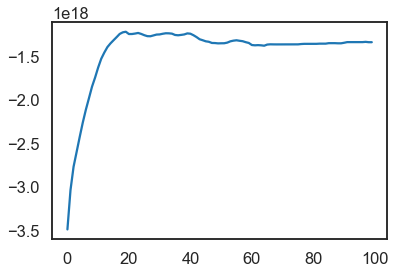

In [63]:
plt.plot(ret)